# INM706 - Deep Learning for Sequence Analysis

Authors: Laerte Adami - Elisa Troschka

Source: 
- https://towardsdatascience.com/a-comprehensive-guide-to-neural-machine-translation-using-seq2sequence-modelling-using-pytorch-41c9b84ba350#30b6
- https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#evaluation

Blue Score:
- https://towardsdatascience.com/foundations-of-nlp-explained-bleu-score-and-wer-metrics-1a5ba06d812b

In [3]:
# Custom functionalities
from Utilities.lstmHandler import EncoderLSTM, DecoderLSTM, AttentionDecoderLSTM
from Utilities.modelHandler import LSTModel
from Utilities.LanguageDataset import LanguageDataset
#from Utilities.TorchtextMetrics import bleu_score

import time
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss as CEL
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

plt.rcParams['font.size'] = 17

In [4]:
## DATASET PARAMETERS ##
data_path = "Data/eng_ita.tsv"
limit_data = 400000
start_token = '<BoS>'
end_token = '<EoS>'
seq_len = 15
embedding_size = 256
batch_size = 100

# Import datasets
dataset = LanguageDataset(data_path = data_path, start_token = start_token, end_token = end_token, seq_len = seq_len, limit_data = limit_data)
train_set, val_set, test_set = dataset.get_datasets()

end_index = dataset.from_ita[end_token]
start_index = dataset.from_ita[start_token]

# Create dataloaders
trainloader = DataLoader(train_set, batch_size = batch_size)
valloader = DataLoader(val_set, batch_size = batch_size)
testloader = DataLoader(test_set, batch_size = batch_size)

# Vocabulary for BLUE score
blue_voc = dataset.blue_score_test

print("English vocabulary size for training: {}".format(dataset.eng_voc_size))
print("Italian vocabulary size for training: {}".format(dataset.ita_voc_size))
print("--------------------------------------------")
print("Train set dimension: {}".format(train_set.__len__()))
print("Val set dimension: {}".format(val_set.__len__()))
print("Test set dimension: {}".format(test_set.__len__()))

English vocabulary size for training: 18639
Italian vocabulary size for training: 31632
--------------------------------------------
Train set dimension: 140027
Val set dimension: 20068
Test set dimension: 39905


## Model defition

In [5]:
encoder = EncoderLSTM(vocabulary_size = dataset.eng_voc_size,
                     embedding_size = embedding_size,
                     num_layers = 1, 
                     bidirectional = False)

#decoder = DecoderLSTM(vocabulary_size = dataset.ita_voc_size,
#                     embedding_size = embedding_size,
#                     num_layers = 1, 
#                     bidirectional = False)

decoder = AttentionDecoderLSTM(vocabulary_size = dataset.ita_voc_size,
                     embedding_size = embedding_size,
                     seq_len = dataset.seq_len,
                     num_layers = 1, 
                     bidirectional = False)

loss_func = CEL()
learning_rate = 1e-4
model = LSTModel(encoder = encoder, 
                 decoder = decoder, 
                 encoder_optimizer = Adam(encoder.parameters(), lr = learning_rate), 
                 decoder_optimizer = Adam(decoder.parameters(), lr = learning_rate),
                 loss_function = loss_func, 
                 eos_token = end_index, 
                 bos_token = start_index)

## Model training

EPOCH 1: train loss = 3.291, validation loss = 2.891
EPOCH 2: train loss = 2.793, validation loss = 2.76
EPOCH 3: train loss = 2.653, validation loss = 2.65
EPOCH 4: train loss = 2.532, validation loss = 2.558
EPOCH 5: train loss = 2.424, validation loss = 2.481
EPOCH 6: train loss = 2.327, validation loss = 2.414
EPOCH 7: train loss = 2.239, validation loss = 2.358
EPOCH 8: train loss = 2.156, validation loss = 2.309
EPOCH 9: train loss = 2.079, validation loss = 2.265
EPOCH 10: train loss = 2.009, validation loss = 2.228
EPOCH 11: train loss = 1.944, validation loss = 2.191
EPOCH 12: train loss = 1.882, validation loss = 2.159
EPOCH 13: train loss = 1.824, validation loss = 2.13
EPOCH 14: train loss = 1.768, validation loss = 2.103
EPOCH 15: train loss = 1.716, validation loss = 2.08
EPOCH 16: train loss = 1.668, validation loss = 2.053
EPOCH 17: train loss = 1.627, validation loss = 2.046
EPOCH 18: train loss = 1.582, validation loss = 2.015
EPOCH 19: train loss = 1.535, validation 

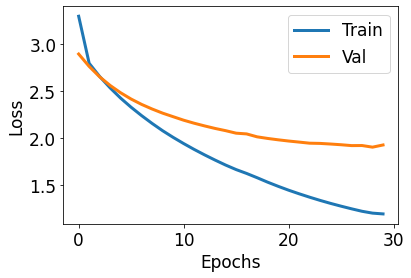

In [9]:
start_time = time.time()
L_train, L_val = model.train_model(trainloader,
                      valloader,
                      max_epochs = 60,
                      save_every_epochs = 20,
                      ckp_name = 'test')
print("--------------------------------")
print("Time required: {}".format(time.time()-start_time))
      
fig, ax = plt.subplots()
ax.plot(L_train, linewidth = 3, label = "Train")
ax.plot(L_val, linewidth = 3, label = "Val")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend();

## Model evaluation

In [6]:
enc_ckp = "test_enc_30.pth"
dec_ckp = "test_dec_30.pth"

X, y, trans = model.evaluate_model(testloader, enc_ckp = enc_ckp, dec_ckp = dec_ckp)

X_blue = dataset.translate(X,"eng")
y_blue = dataset.translate(y,"ita")
trans_blue = dataset.translate(trans,"ita")

In [7]:
ids = 34
print("English: " + ' '.join(X_blue[ids]))
print("Italian: " + ' '.join(y_blue[ids]))
print("Translation: " + ' '.join(trans_blue[ids]))

English: You re German aren t you
Italian: Sei tedesco vero
Translation: Conoscevo approvo approvo approvo approvo approvo approvo approvo approvo approvo approvo approvo approvo approvo


In [8]:
ids = 12
print("English: " + ' '.join(X_blue[ids]))
print("Italian: " + ' '.join(y_blue[ids]))
print("Translation: " + ' '.join(trans_blue[ids]))

English: Could you have done it
Italian: Voi avreste potuto farla
Translation: Middleton approvo approvo approvo approvo approvo approvo approvo approvo approvo approvo approvo approvo approvo


In [9]:
ids = 67
print("English: " + ' '.join(X_blue[ids]))
print("Italian: " + ' '.join(y_blue[ids]))
print("Translation: " + ' '.join(trans_blue[ids]))

English: How are things with you and Tom
Italian: Come vanno le cose tra voi e Tom
Translation: Middleton approvo approvo approvo approvo approvo approvo approvo approvo approvo approvo approvo approvo approvo


## BLUE score

In [19]:
len(candidate_corpus)

1

In [18]:
id_test = 12

candidate_corpus = [trans_blue[id_test]]
reference_corpus = blue_voc[' '.join(X_blue[id_test])]

print(f"Candidate corpus: {candidate_corpus}")
print(f"Reference corpus: {reference_corpus}")
print("----------------")
bs = bleu_score(candidate_corpus, reference_corpus, max_n = 1, weights=[1])#[0.5, 0.5])
print(f"Blue score : {bs}")
print("----------------")

Candidate corpus: [['Il', 'è', 'è', 'è']]
Reference corpus: [['Il', 'server', 'non', 'funziona'], ['Il', 'server', 'è', 'fuori', 'servizio']]
----------------


AssertionError: The length of candidate and reference corpus should be the same

In [ ]:
bs_list = []

for id_test, test in enumerate (trans_blue):
    candidate_corpus = [trans_blue[id_test]]
    reference_corpus = blue_voc[' '.join(X_blue[id_test])]
        
    bs = bleu_score(candidate_corpus, references_corpus, max_n = 4, weights=[0.25, 0.25, 0.25,0.25])
    bs_list.append(bs)

In [ ]:
sum(bs_list)/len(bs_list)

In [ ]:
max(bs_list)